In [1]:
##########################################################################
# Created on Sat Nov 13 22:37:45 2021                                    #
# Python for Financial Analysis and Risk Management                      #
# @author: Meng Lipeng (FRM, CFA)                                        #
##########################################################################

# 11.5.2.Generalized mathematical expression

American call option,\
$$V_{i,j}=max\left\{S_0u^jd^{i-j}-K,\left[pV_{i+1,j+1}+(1-p)V_{i+1,j}\right]e^{-r\Delta t}\right\}\tag{11-36}$$
American put option,\
$$V_{i,j}=max\left\{K-S_0u^jd^{i-j},\left[pV_{i+1,j+1}+(1-p)V_{i+1,j}\right]e^{-r\Delta t}\right\}\tag{11-37}$$

# 11.5.3.Using matrix operation

Put underlying asset price in an upper triangular matrix\
$$S=\begin{bmatrix}
S_0    & S_0u   & \ldots & S_0u^{N-1} & S_0u^N \\
0      & S_0d   & \ldots & S_0u^{N-2} & S_0u^{N-1}d \\
\vdots & \vdots & \ddots & \vdots     & \vdots \\
0      & 0      & \ldots & S_0d^{N-1} & S_0ud^{N-1} \\
0      & 0      & \ldots & 0          & S_0d^{N}
\end{bmatrix}\tag{11-38}$$

Option price when expires\
$$C=\begin{bmatrix}
0      & 0      & \ldots & 0          & max(S_0u^N-K,0) \\
0      & 0      & \ldots & 0          & max(S_0u^{N-1}d-K,0) \\
\vdots & \vdots & \ddots & \vdots     & \vdots \\
0      & 0      & \ldots & 0          & max(S_0ud^{N-1}-K,0) \\
0      & 0      & \ldots & 0          & max(S_0d^{N}-K,0)
\end{bmatrix}\tag{11-39}$$

By repeatedly applying (11-39) and combining (11-36), we can successively obtain the non-zero elements in column N and the non-zero elements in column N-1 of matrix C.

In [6]:
def American_call(S,K,sigma,r,T,N):
    '''Define a function to calculate American call option price using N steps binomial tree.
    S:underlying price at t0
    K:strike price
    sigma:volatility of underlying asset return(annualized)
    r:risk free rate(continuous compound)
    T:tenor in year
    N:number of step in the BTM model'''

    import numpy as np
    
    # Step1:Calculate relevant parameters
    t=T/N
    u=np.exp(sigma*np.sqrt(t))
    d=1/u
    p=(np.exp(r*t)-d)/(u-d)
    call_matrix=np.zeros((N+1,N+1))
    
    # Step2:Calculate the underlying asset price and option value at the option maturity node
    N_list=np.arange(0,N+1)
    S_end=S*pow(u,N-N_list)*pow(d,N_list)
    call_matrix[:,-1]=np.maximum(S_end-K,0)
    
    #Step3:Calculate the underlying asset price and option value at the non maturity node of the option
    i_list=list(range(0,N))
    i_list.reverse()
    for i in i_list:
        j_list=np.arange(i+1)
        Si=S*pow(u,i-j_list)*pow(d,j_list)
        call_strike=np.maximum(Si-K,0)
        call_nostrike=(p*call_matrix[:i+1,i+1]+(1-p)*call_matrix[1:i+2,i+1])*np.exp(-r*t)
        call_matrix[:i+1,i]=np.maximum(call_strike,call_nostrike)
    call_begin=call_matrix[0,0]
    
    return call_begin

In [7]:
def American_put(S,K,sigma,r,T,N):
    '''Define a function to calculate American put option price using N steps binomial tree.
    S:underlying price at t0
    K:strike price
    sigma:volatility of underlying asset return(annualized)
    r:risk free rate(continuous compound)
    T:tenor in year
    N:number of step in the BTM model'''

    import numpy as np
    
    # Step1:Calculate relevant parameters
    t=T/N
    u=np.exp(sigma*np.sqrt(t))
    d=1/u
    p=(np.exp(r*t)-d)/(u-d)
    put_matrix=np.zeros((N+1,N+1))
    
    # Step2:Calculate the underlying asset price and option value at the option maturity node
    N_list=np.arange(0,N+1)
    S_end=S*pow(u,N-N_list)*pow(d,N_list)
    put_matrix[:,-1]=np.maximum(K-S_end,0)
    
    #Step3:Calculate the underlying asset price and option value at the non maturity node of the option
    i_list=list(range(0,N))
    i_list.reverse()
    for i in i_list:
        j_list=np.arange(i+1)
        Si=S*pow(u,i-j_list)*pow(d,j_list)
        put_strike=np.maximum(K-Si,0)
        put_nostrike=(p*put_matrix[:i+1,i+1]+(1-p)*put_matrix[1:i+2,i+1])*np.exp(-r*t)
        put_matrix[:i+1,i]=np.maximum(put_strike,put_nostrike)
    put_begin=put_matrix[0,0]
    return put_begin

In [8]:
import pandas as pd
import numpy as np

Price_BOC=pd.read_excel('BOC daily close price(2017-20200207).xlsx',engine='openpyxl',sheet_name="Sheet1",header=0,index_col=0)
R_BOC=np.log(Price_BOC/Price_BOC.shift(1))
Sigma_BOC=np.sqrt(252)*np.std(R_BOC)
Sigma_BOC=float(Sigma_BOC)
print('Annualized volatility of BOC is ',round(Sigma_BOC,4))

Annualized volatility of BOC is  0.1676


In [9]:
S_BOC=3.5
K_BOC=3.8
T_BOC=1
r_Feb10=0.02
N_2=2

Put_2step=American_put(S=S_BOC,K=K_BOC,sigma=Sigma_BOC,r=r_Feb10,T=T_BOC,N=N_2)
print('American Put option price using 2 steps binomial tree is ',round(Put_2step,4))

American Put option price using 2 steps binomial tree is  0.4069


In [10]:
N_12=12
N_52=52
N_252=252

Put_12step=American_put(S=S_BOC,K=K_BOC,sigma=Sigma_BOC,r=r_Feb10,T=T_BOC,N=N_12)
Put_52step=American_put(S=S_BOC,K=K_BOC,sigma=Sigma_BOC,r=r_Feb10,T=T_BOC,N=N_52)
Put_252step=American_put(S=S_BOC,K=K_BOC,sigma=Sigma_BOC,r=r_Feb10,T=T_BOC,N=N_252)

print('American Put option price using 12 steps binomial tree is ',round(Put_12step,4))
print('American Put option price using 52 steps binomial tree is ',round(Put_52step,4))
print('American Put option price using 252 steps binomial tree is ',round(Put_252step,4))

American Put option price using 12 steps binomial tree is  0.3847
American Put option price using 52 steps binomial tree is  0.3853
American Put option price using 252 steps binomial tree is  0.3849


# 11.5.4.Relationship between American and European option

In [12]:
import utils

K1=3.0
K2=3.5
K3=4.0

Euro_call_K1=utils.BTM_Nstep(S=S_BOC,K=K1,sigma=Sigma_BOC,r=r_Feb10,T=T_BOC,N=N_252,types='call')
Amer_call_K1=American_call(S=S_BOC,K=K1,sigma=Sigma_BOC,r=r_Feb10,T=T_BOC,N=N_252)
Euro_call_K2=utils.BTM_Nstep(S=S_BOC,K=K2,sigma=Sigma_BOC,r=r_Feb10,T=T_BOC,N=N_252,types='call')
Amer_call_K2=American_call(S=S_BOC,K=K2,sigma=Sigma_BOC,r=r_Feb10,T=T_BOC,N=N_252)
Euro_call_K3=utils.BTM_Nstep(S=S_BOC,K=K3,sigma=Sigma_BOC,r=r_Feb10,T=T_BOC,N=N_252,types='call')
Amer_call_K3=American_call(S=S_BOC,K=K3,sigma=Sigma_BOC,r=r_Feb10,T=T_BOC,N=N_252)

print('European Call option(Strike=3.0) price is ',Euro_call_K1)
print('American Call option(Strike=3.0) price is ',Amer_call_K1)
print('European Call option(Strike=3.5) price is ',Euro_call_K2)
print('American Call option(Strike=3.5) price is ',Amer_call_K2)
print('European Call option(Strike=4.0) price is ',Euro_call_K3)
print('American Call option(Strike=4.0) price is ',Amer_call_K3)

European Call option(Strike=3.0) price is  0.6009336736887524
American Call option(Strike=3.0) price is  0.6009336736887604
European Call option(Strike=3.5) price is  0.26751274557721655
American Call option(Strike=3.5) price is  0.26751274557722005
European Call option(Strike=4.0) price is  0.09207459670132756
American Call option(Strike=4.0) price is  0.09207459670132873


In [13]:
Euro_put_K1=utils.BTM_Nstep(S=S_BOC,K=K1,sigma=Sigma_BOC,r=r_Feb10,T=T_BOC,N=N_252,types='put')
Amer_put_K1=American_put(S=S_BOC,K=K1,sigma=Sigma_BOC,r=r_Feb10,T=T_BOC,N=N_252)
Euro_put_K2=utils.BTM_Nstep(S=S_BOC,K=K2,sigma=Sigma_BOC,r=r_Feb10,T=T_BOC,N=N_252,types='put')
Amer_put_K2=American_put(S=S_BOC,K=K2,sigma=Sigma_BOC,r=r_Feb10,T=T_BOC,N=N_252)
Euro_put_K3=utils.BTM_Nstep(S=S_BOC,K=K3,sigma=Sigma_BOC,r=r_Feb10,T=T_BOC,N=N_252,types='put')
Amer_put_K3=American_put(S=S_BOC,K=K3,sigma=Sigma_BOC,r=r_Feb10,T=T_BOC,N=N_252)

print('European Put option(Strike=3.0) price is ',Euro_put_K1)
print('American Put option(Strike=3.0) price is ',Amer_put_K1)
print('European Put option(Strike=3.5) price is ',Euro_put_K2)
print('American Put option(Strike=3.5) price is ',Amer_put_K2)
print('European Put option(Strike=4.0) price is ',Euro_put_K3)
print('American Put option(Strike=4.0) price is ',Amer_put_K3)

European Put option(Strike=3.0) price is  0.041529693609017926
American Put option(Strike=3.0) price is  0.042376999395400884
European Put option(Strike=3.5) price is  0.19820810215085993
American Put option(Strike=3.5) price is  0.2045321168794166
European Put option(Strike=4.0) price is  0.5128692899283482
American Put option(Strike=4.0) price is  0.5371245309809153


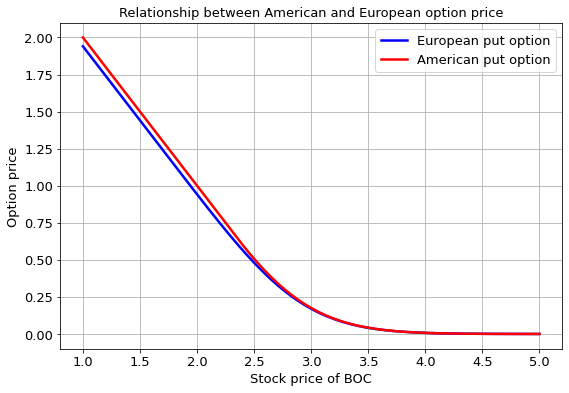

In [14]:
import matplotlib.pyplot as plt

S_BOC_list=np.linspace(1.0,5.0,200)
Euro_put_list=np.zeros_like(S_BOC_list)
Amer_put_list=np.zeros_like(S_BOC_list)

for i in range(len(S_BOC_list)):
    Euro_put_list[i]=utils.BTM_Nstep(S=S_BOC_list[i],K=K1,sigma=Sigma_BOC,r=r_Feb10,T=T_BOC,N=N_252,types='put')
    Amer_put_list[i]=American_put(S=S_BOC_list[i],K=K1,sigma=Sigma_BOC,r=r_Feb10,T=T_BOC,N=N_252)

plt.figure(figsize=(9,6))
plt.plot(S_BOC_list,Euro_put_list,'b-',label='European put option',lw=2.5)
plt.plot(S_BOC_list,Amer_put_list,'r-',label='American put option',lw=2.5)
plt.xlabel('Stock price of BOC',fontsize=13)
plt.xticks(fontsize=13)
plt.ylabel('Option price',fontsize=13)
plt.yticks(fontsize=13)
plt.title('Relationship between American and European option price',fontsize=13)
plt.legend(fontsize=13)
plt.grid()
plt.show()

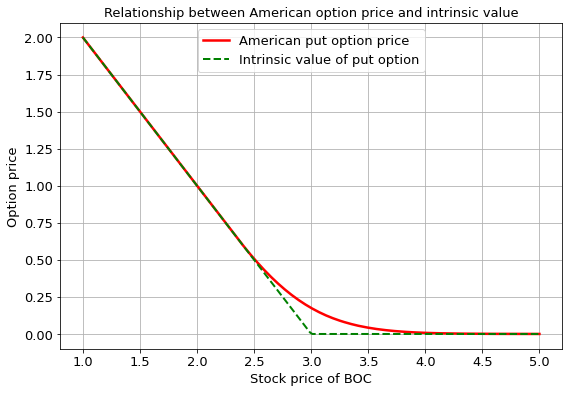

In [15]:
Intrinsic_value=np.maximum(K1-S_BOC_list,0)

plt.figure(figsize=(9,6))
plt.plot(S_BOC_list,Amer_put_list,'r-',label='American put option price',lw=2.5)
plt.plot(S_BOC_list,Intrinsic_value,'g--',label='Intrinsic value of put option',lw=2.0)
plt.xlabel('Stock price of BOC',fontsize=13)
plt.xticks(fontsize=13)
plt.ylabel('Option price',fontsize=13)
plt.yticks(fontsize=13)
plt.title('Relationship between American option price and intrinsic value',fontsize=13)
plt.legend(fontsize=13,loc=9)
plt.grid()
plt.show()

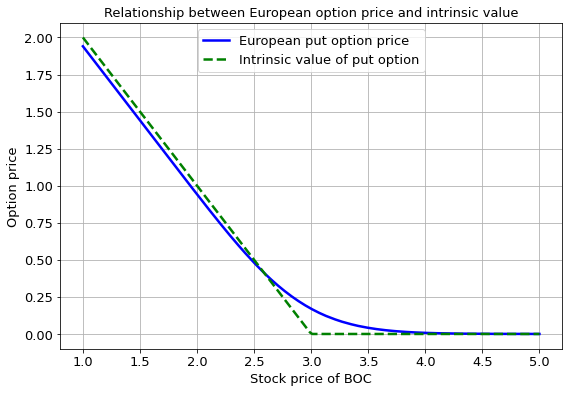

In [16]:
plt.figure(figsize=(9,6))
plt.plot(S_BOC_list,Euro_put_list,'b-',label='European put option price',lw=2.5)
plt.plot(S_BOC_list,Intrinsic_value,'g--',label='Intrinsic value of put option',lw=2.5)
plt.xlabel('Stock price of BOC',fontsize=13)
plt.xticks(fontsize=13)
plt.ylabel('Option price',fontsize=13)
plt.yticks(fontsize=13)
plt.title('Relationship between European option price and intrinsic value',fontsize=13)
plt.legend(fontsize=13,loc=9)
plt.grid()
plt.show()